In [1]:
!pip install seaborn

In [2]:
import os
import scipy.io

# Define data path
datapath = './data/'  # Assuming the data files are located in the 'data' folder in the current directory

# Get list of all subject files (18 participants)
file_list = [f for f in os.listdir(datapath) if f.startswith('P') and f.endswith('.mat')]

# Initialize a list to store the data for all subjects
all_participants_data = []

# Load all participant data once
for file_name in file_list:
    file_path = os.path.join(datapath, file_name)
    
    # Load data structure and append to list
    mat_data = scipy.io.loadmat(file_path)
    all_participants_data.append(mat_data)

# Now 'all_participants_data' contains the data of all subjects.


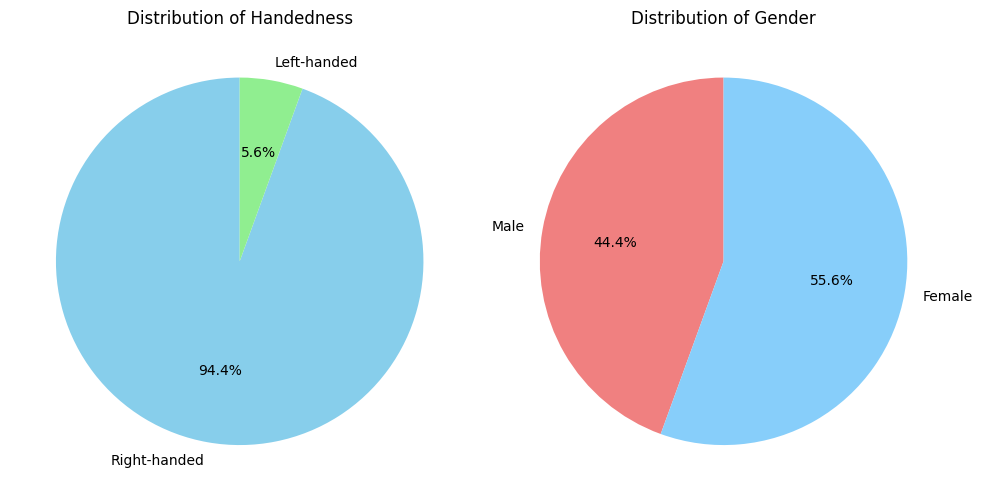

In [3]:
#| label: HandednessGenderPieChart

# Initialize counters for handedness and gender
handedness_count = {'right': 0, 'left': 0}
gender_count = {'male': 0, 'female': 0}

# Loop through all loaded participant data
for participant_data in all_participants_data:
    subject_info = participant_data['subject']
    
    # Extract handedness and gender information, convert to string and clean
    gender = str(subject_info['sex'][0][0][0]).lower().strip()  # 'male' or 'female'
    handedness = str(subject_info['handedness'][0][0][0]).lower().strip()  # 'right' or 'left'
    
    # Update counters
    if handedness in handedness_count:
        handedness_count[handedness] += 1
    if gender in gender_count:
        gender_count[gender] += 1

# Prepare data for plotting
handedness_labels = ['Right-handed', 'Left-handed']
gender_labels = ['Male', 'Female']

# Handedness distribution
handedness_values = [handedness_count['right'], handedness_count['left']]

# Gender distribution
gender_values = [gender_count['male'], gender_count['female']]

# Plot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Handedness pie chart
axes[0].pie(handedness_values, labels=handedness_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[0].set_title('Distribution of Handedness')

# Gender pie chart
axes[1].pie(gender_values, labels=gender_labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
axes[1].set_title('Distribution of Gender')

plt.tight_layout()
plt.show()


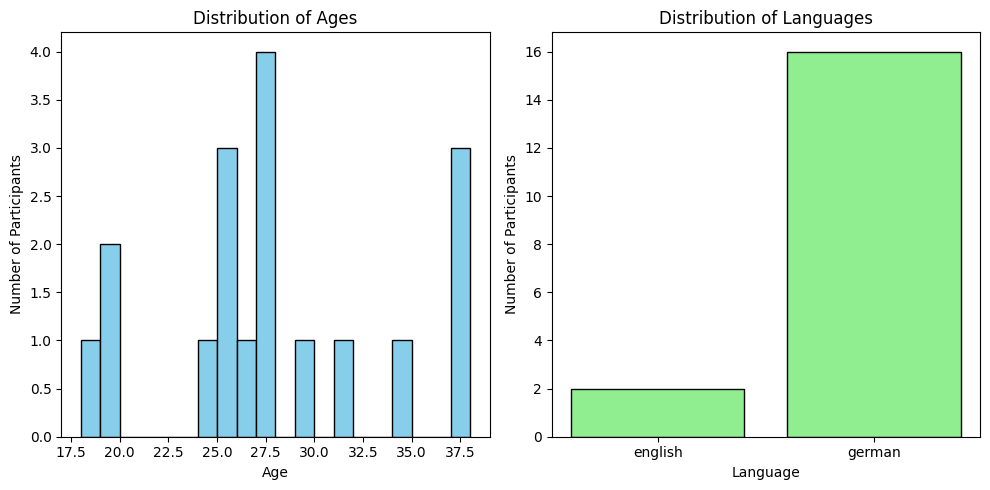

In [4]:
#| label: AgeLanguageDist
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to collect demographic data
ages = []
languages = []

# Loop through all loaded participant data to extract demographic information
for participant_data in all_participants_data:
    subject_info = participant_data['subject']
    
    # Extract age and language
    age = int(subject_info[0][0][0][0])  # Age is stored as an integer
    language = str(subject_info[0][0][3][0])  # Language is stored as a string
    
    # Append to the lists
    ages.append(age)
    languages.append(language)

# Convert lists to NumPy arrays for easier manipulation if needed
ages = np.array(ages)
languages = np.array(languages)

# --- Plot 1: Distribution of Ages ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(ages, bins=np.arange(min(ages), max(ages)+1, 1), color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Number of Participants')

# --- Plot 2: Distribution of Languages ---
plt.subplot(1, 2, 2)
unique_languages, counts = np.unique(languages, return_counts=True)
plt.bar(unique_languages, counts, color='lightgreen', edgecolor='black')
plt.title('Distribution of Languages')
plt.xlabel('Language')
plt.ylabel('Number of Participants')

plt.tight_layout()
plt.show()


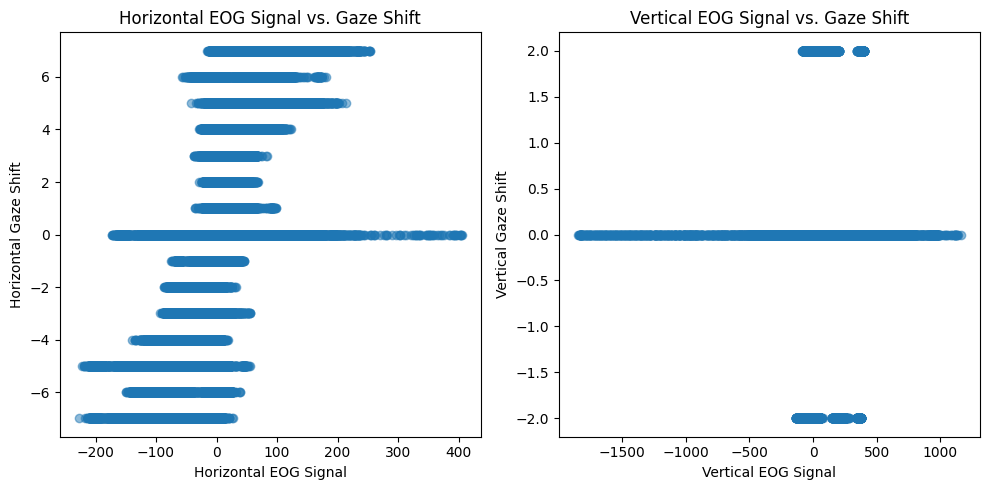

In [5]:
#| label: EOGVsGazeShift

# Initialize lists to collect EOG and gaze shift data across participants
all_heog = []
all_veog = []
all_xdeg = []
all_ydeg = []

# Loop through all loaded participant data
for participant_data in all_participants_data:
    eyemov = participant_data['eyemov']
    
    # Extract Horizontal and Vertical EOG signals
    heog = eyemov['heog'][0, 0].flatten()  # Horizontal EOG
    veog = eyemov['veog'][0, 0].flatten()  # Vertical EOG
    
    # Extract Gaze shift (degrees)
    xdeg = eyemov['xdeg'][0, 0].flatten()  # Horizontal gaze shift
    ydeg = eyemov['ydeg'][0, 0].flatten()  # Vertical gaze shift
    
    # Append to lists
    all_heog.append(heog)
    all_veog.append(veog)
    all_xdeg.append(xdeg)
    all_ydeg.append(ydeg)

# Convert lists to NumPy arrays
all_heog = np.concatenate(all_heog)
all_veog = np.concatenate(all_veog)
all_xdeg = np.concatenate(all_xdeg)
all_ydeg = np.concatenate(all_ydeg)

# Plot scatter plot of EOG signals vs. gaze shift
plt.figure(figsize=(10, 5))

# Horizontal EOG vs. Gaze Shift
plt.subplot(1, 2, 1)
plt.scatter(all_heog, all_xdeg, alpha=0.5)
plt.title('Horizontal EOG Signal vs. Gaze Shift')
plt.xlabel('Horizontal EOG Signal')
plt.ylabel('Horizontal Gaze Shift')

# Vertical EOG vs. Gaze Shift
plt.subplot(1, 2, 2)
plt.scatter(all_veog, all_ydeg, alpha=0.5)
plt.title('Vertical EOG Signal vs. Gaze Shift')
plt.xlabel('Vertical EOG Signal')
plt.ylabel('Vertical Gaze Shift')

plt.tight_layout()
plt.show()


# ReRun Experiment

In [1]:
import numpy as np
from scipy.stats import pearsonr

def applyfilter(T, data, model):
    """
    Applies a spatial filter to the data and model matrices and returns predictions.

    Parameters:
    - T: dict, contains the spatial filter matrices T['A'] and T['B'] and class labels T['classes']
    - data: np.ndarray, preprocessed EEG data (channels x samples x stimuli x trials)
    - model: np.ndarray, model matrices (samples x samples x stimuli x trials)

    Returns:
    - prediction: list, predicted classes for each trial
    """
    predictions = []

    # Loop over trials
    for tr in range(data.shape[3]):
        # Concatenate stimuli within a trial
        X = data[:, :, :, tr].transpose(1, 2, 0).reshape(data.shape[1] * data.shape[2], data.shape[0])
        
        # Apply spatial filter to data
        X_filtered = X @ T['A']

        # Reshape model matrix representing canonical difference waves and apply spatial filter
        Y = model[:, :, :, tr].transpose(1, 2, 0).reshape(model.shape[1] * model.shape[2], model.shape[0]) @ T['B']

        # Calculate correlations
        R = np.array([pearsonr(X_filtered[:, i], Y[:, i])[0] for i in range(X_filtered.shape[1])])
        
        # Find the highest absolute correlation
        hR = np.max(np.abs(R))
        hP = np.argmax(np.abs(R))

        # Map result to class based on the sign of the correlation
        predicted_class = T['classes'][1 - int(R[hP] > 0)]
        predictions.append(predicted_class)

    return predictions


In [2]:
import numpy as np
from sklearn.cross_decomposition import CCA

def filterspatially(data, model, label):
    """
    Constructs a spatial filter using Canonical Correlation Analysis (CCA) on the data and model matrices.

    Parameters:
    - data: np.ndarray, EEG data (channels x samples x stimuli x trials)
    - model: np.ndarray, model matrices (samples x samples x stimuli x trials)
    - label: list, labels for each trial ('yes' or 'no')

    Returns:
    - T: dict, contains spatial filter matrices T['A'] and T['B'], correlation coefficients, and statistics
    """
    T = {'classes': ['yes', 'no']}

    # Define data matrix sizes
    nChan = data.shape[0]
    nTrialSamp = data.shape[1] * data.shape[2]
    
    # Initialize X and Y for concatenated data and model matrices
    X = np.zeros((nTrialSamp * data.shape[3], nChan))
    Y = np.zeros((nTrialSamp * model.shape[3], model.shape[0]))
    
    idx = 0
    
    # Concatenate trials
    for tr in range(data.shape[3]):
        # Index range for each trial
        idx_range = np.arange(idx, idx + nTrialSamp)
        
        # Reshape and permute data and model
        X[idx_range, :] = data[:, :, :, tr].transpose(1, 2, 0).reshape(nTrialSamp, nChan)
        
        # Map labels: positive if 'yes' (class 1), negative otherwise
        y_sign = (1 if label[tr] == T['classes'][0] else -1)
        Y[idx_range, :] = y_sign * model[:, :, :, tr].transpose(1, 2, 0).reshape(nTrialSamp, model.shape[0])
        
        idx += nTrialSamp

    # Perform CCA to find weights that maximize correlation
    cca = CCA(n_components=min(nChan, Y.shape[1]))  # Limit components to available channels or Y size
    X_c, Y_c = cca.fit_transform(X, Y)
    
    # Store canonical coefficients and correlation values in T
    T['A'] = cca.x_weights_
    T['B'] = cca.y_weights_
    T['R'] = np.corrcoef(X_c.T, Y_c.T)[:X_c.shape[1], X_c.shape[1]:].diagonal()  # Diagonal of correlation matrix

    # Statistics (approximation of significance using correlation threshold)
    p_vals = 1 - np.abs(T['R'])  # Placeholder for significance test; adjust as needed
    significantChans = np.where(p_vals < 0.05)[0]
    
    # Ensure a minimum of two channels are selected
    if len(significantChans) < 2:
        significantChans = np.arange(2)
    
    # Filter channels based on significance
    T['A'] = T['A'][:, significantChans]
    T['B'] = T['B'][:, significantChans]
    T['R'] = T['R'][significantChans]
    T['STATS'] = {'p': p_vals[significantChans]}

    return T


In [4]:
import numpy as np

def crossvalidate(data, model, label):
    """
    Perform leave-one-run-out cross-validation on the BCI data.

    Parameters:
    - data: np.ndarray, preprocessed EEG data (channels x samples x stimuli x trials)
    - model: np.ndarray, model matrices (samples x samples x stimuli x trials)
    - label: list or np.ndarray, labels for each trial (usually the intention of the participant)

    Returns:
    - perf: dict, containing accuracy and predicted labels
    """
    # Define the number of runs (considering each run has 24 trials)
    num_trials = data.shape[3]
    nRuns = num_trials // 24  # Determine how many runs are available

    # Initialize performance metrics
    perf = {'label': label, 'prediction': [None] * len(label)}

    # Start leave-one-run-out cross-validation
    for run_idx in range(nRuns):
        # Determine test and training indices for leave-one-run-out
        start_idx = run_idx * 24
        end_idx = start_idx + 24

        testIdx = np.arange(start_idx, end_idx)
        trainIdx = np.setdiff1d(np.arange(num_trials), testIdx)

        # Apply CCA-based spatial filter approach using training data
        T = filterspatially(data[:, :, :, trainIdx], model[:, :, :, trainIdx], label[trainIdx])

        # Apply estimated correlation coefficients to decode the sequence on the test data
        perf['prediction'][start_idx:end_idx] = applyfilter(T, data[:, :, :, testIdx], model[:, :, :, testIdx])

    # Calculate accuracy
    correct_predictions = sum(np.array(perf['prediction']) == np.array(perf['label']))
    perf['accuracy'] = correct_predictions / len(perf['label'])

    return perf


In [6]:
import numpy as np
from scipy.signal import butter, filtfilt, resample

def preprocess(bciexp):
    """
    Preprocesses the BCI experiment data by segmenting, filtering, and downsampling.

    Parameters:
    - bciexp: dict, contains EEG data and related fields from the experiment

    Returns:
    - data: np.ndarray, preprocessed EEG data (channels x samples x stimuli x trials)
    - model: np.ndarray, model matrices (samples x samples x stimuli x trials)
    """
    # Define parameters
    downsampfac = 5  # downsampling factor (250 Hz / 5 = 50 Hz)
    passband = [1, 12.5]  # cutoff frequencies for bandpass filter
    interval_length = 0.75  # length of analysis interval in seconds

    # Define parieto-occipital channels of interest
    chanOfInterest = ['O9', 'CP1', 'CP2', 'O10', 'P7', 'P3', 'Pz', 'P4', 
                      'P8', 'PO7', 'PO3', 'Oz', 'PO4', 'PO8']
    
    # Unwrap EEG data from nested structure
    data_raw = bciexp['data'][0, 0]  # Shape: (channels, samples, trials)

    # Determine channel mapping by converting each label to a string and checking if it's in chanOfInterest
    chans = [i for i, lbl in enumerate(bciexp['label'][0]) if str(lbl[0]) in chanOfInterest]

    # Left mastoid channel for re-referencing
    # Convert label to string for comparison
    lmastchan = next((i for i, lbl in enumerate(bciexp['label'][0]) if str(lbl[0]) == 'LMAST'), None)

    # Bandpass filter coefficients
    butter_b, butter_a = butter(2, [passband[0] / (bciexp['srate'][0, 0] / 2), passband[1] / (bciexp['srate'][0, 0] / 2)], btype='band')

    # Number of samples per analysis window
    nWinSamp = int(np.floor(interval_length * bciexp['srate'][0, 0] / downsampfac) - 1)

    # Define interval relative to stimulus onset
    interval = np.arange(nWinSamp)

    # Number of stimuli per trial
    nStim = int(np.sum(np.diff(np.sum(bciexp['stim'][0, 0], axis=0)) > 0))

    # Number of available trials
    nTrials = data_raw.shape[2]

    # Number of channels
    nChan = len(chans)

    # Initialize matrices for segmented data and model functions
    data = np.zeros((nChan, nWinSamp, nStim, nTrials))
    model = np.zeros((nWinSamp, nWinSamp, nStim, nTrials))

    # Loop over all trials
    for tr in range(nTrials):
        # Right mastoid was reference; re-reference to (RMAST + LMAST) / 2 if LMAST exists
        if lmastchan is not None:
            rdat = data_raw[chans, :, tr] - (data_raw[lmastchan, :, tr] / 2)
        else:
            rdat = data_raw[chans, :, tr]  # No re-referencing if LMAST is not found

        # Filter and downsample the data
        rdat_filtered = filtfilt(butter_b, butter_a, rdat, axis=1)
        rdat_resampled = resample(rdat_filtered, rdat_filtered.shape[1] // downsampfac, axis=1)

        # Extract stimulus information for each trial
        stim_green_left = np.diff(np.concatenate(([0], bciexp['stim'][0, 0][:, tr].flatten()))) > 0

        # Check if the second stimulus channel exists
        if bciexp['stim'].shape[0] > 1:
            stim_red_left = np.diff(np.concatenate(([0], bciexp['stim'][1, 0][:, tr].flatten()))) > 0
        else:
            stim_red_left = np.zeros_like(stim_green_left)

        stim = (stim_green_left.astype(int) - stim_red_left.astype(int))

        # Determine stimulus onsets
        stim_onsets = np.where(stim != 0)[0]

        # Loop over all stimuli in a trial
        for st in range(min(nStim, len(stim_onsets))):
            # Determine interval for the stimulus onset
            idx = np.ceil(stim_onsets[st] / downsampfac).astype(int) + interval

            # Make sure that idx doesn't exceed the available length of rdat_resampled
            idx = idx[idx < rdat_resampled.shape[1]]

            # Cut out the resampled data for the interval
            data[:, :len(idx), st, tr] = rdat_resampled[:, idx]

            # Map left green cross presentations to positive Identity matrix,
            # and left red cross presentations to negative Identity matrix
            model[:len(idx), :len(idx), st, tr] = stim[stim_onsets[st]] * np.eye(len(idx))
    
    return data, model


In [ ]:
import os
import scipy.io
import numpy as np

# Define the data path

datapath = './data/' 
# Get list of files for all subjects
file_list = [f for f in os.listdir(datapath) if f.startswith('P') and f.endswith('.mat')]

if not file_list:
    print("Data not found. Please define the correct data path.")


# Process each file
for file_name in file_list[2:3]:
    print(f"Analyzing {file_name}...")
    # Load data structure
    file_path = os.path.join(datapath, file_name)
    data_struct = scipy.io.loadmat(file_path)
    bciexp = data_struct['bciexp']  # Extract 'bciexp' field
    
    # Preprocess data
    data, model = preprocess(bciexp)
    
    # Perform leave-one-run-out cross-validation
    perf = crossvalidate(data, model, bciexp['intention'][0])
    print(f"Accuracy = {perf['accuracy'] * 100:.2f}%")
